INSTALLING PACKAGES

In [ ]:
!pip install python-dotenv gradientai datasets llama-index llama-index-llms-gradient llama-index-finetuning langchain langchain_community langchain_huggingface pymupdf arxiv faiss-cpu -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.7/397.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.5/975.5 kB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

INITIALIZE GRADIENTAI WORKSPACE AND KEY INFORMATION

In [ ]:
from dotenv import dotenv_values
import openai

env_vars = dotenv_values('/content/drive/MyDrive/Colab Notebooks/RAG/env.txt')

gradientai_workspace_id = env_vars['GRADIENT_WORKSPACE_ID']
gradientai_api_key = env_vars['GRADIENT_ACCESS_TOKEN']


We are going to use **llama2-7b-chat** for inference and will fine-tune it to follow instructions

We are going to use [GradientAI](https://gradient.ai/).
Docs are [available here](https://docs.gradient.ai/) for reference and quick start.

Once the registration is complete, we need to note down the workspace_id and create an access token to proceed with consuming GradientAI services.

INITIALIZE GradientAI model for consumption and Instruction-tuning

In [ ]:
from llama_index.llms.gradient import GradientBaseModelLLM

model_version = 'llama2-7b-chat'

gradient_model = GradientBaseModelLLM(
    workspace_id=gradientai_workspace_id,
    access_token=gradientai_api_key,
    base_model_slug=model_version,
    max_tokens=300
)


So now the model is intialized, we need to **prepare the dataset** on which
the model hosted on gradientAI will be used **for Fine-Tuning**.

**llama2-7b-chat** requires the data to be in **jsonl format**.

We will use [mosaicml/instruct-v3](https://huggingface.co/datasets/mosaicml/instruct-v3) dataset which contains the rows in following format :
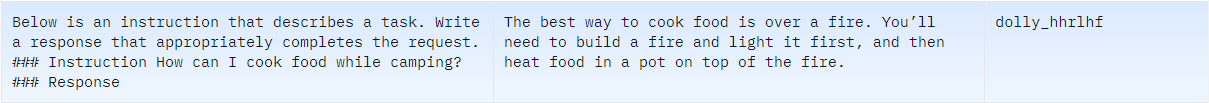

Each row should have an object called inputs which contains your fully formatted prompt.

***NOTE***: Even though we are using a safe content and aligned dataset, we may still see unwanted results if model is not used for its intended purpose.

Lets load the dataset

In [ ]:
from datasets import load_dataset

instruct_tune_dataset = load_dataset("mosaicml/instruct-v3")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/56167 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6807 [00:00<?, ? examples/s]

In [ ]:
instruct_tune_dataset

DatasetDict({
    train: Dataset({
        features: ['prompt', 'response', 'source'],
        num_rows: 56167
    })
    test: Dataset({
        features: ['prompt', 'response', 'source'],
        num_rows: 6807
    })
})

The dataset has 3 columns :

1.  prompt
2.  response
3.  source

We need to combine the prompt and response in a single formatted prompt and name it as *input* for all rows before we can start to fine-tune the model.

####FORMATTED PROMPT

```
<s>### Instruction:
Below is an instruction that describes a task. Write a response that appropriately completes the request.
{USER MESSAGE}

### Response:
{RESPONSE}</s>
```

llama models follows ```[SYS][INST]``` meta-tags but it was found by the llama-index team that ```<s> </s>``` performs a bit better.

In [ ]:
def create_prompt(sample):
  bos_token = "<s>"
  system_message = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
  user_message = sample["prompt"].replace(system_message, "").replace("\n\n### Instruction\n", "").replace("\n### Response\n", "").strip()
  response = sample["response"]
  eos_token = "</s>"

  full_prompt = ""
  full_prompt += bos_token
  full_prompt += "### Instruction:"
  full_prompt += "\n" + system_message
  full_prompt += "\n" + user_message
  full_prompt += "\n\n### Response:"
  full_prompt += "\n" + response
  full_prompt += eos_token

  return {"inputs" : full_prompt}

Lets see how the prompt looks like

In [ ]:
instruct_tune_dataset["train"][1]['prompt']

'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction\nWhat are different types of grass?\n\n### Response\n'

In [ ]:
instruct_tune_dataset["train"][1]['response']

'There are more than 12,000 species of grass. The most common is Kentucky Bluegrass, because it grows quickly, easily, and is soft to the touch. Rygrass is shiny and bright green colored. Fescues are dark green and shiny. Bermuda grass is harder but can grow in drier soil.'

In [ ]:
create_prompt(instruct_tune_dataset["train"][1])['inputs']

'<s>### Instruction:\nBelow is an instruction that describes a task. Write a response that appropriately completes the request.\nWhat are different types of grass?\n\n### Response:\nThere are more than 12,000 species of grass. The most common is Kentucky Bluegrass, because it grows quickly, easily, and is soft to the touch. Rygrass is shiny and bright green colored. Fescues are dark green and shiny. Bermuda grass is harder but can grow in drier soil.</s>'

Now we will map this function to create a field in the dataset by the name 'inputs' which will contain the full prompt.

In [ ]:
dataset_with_full_prompt = instruct_tune_dataset.map(create_prompt)

Map:   0%|          | 0/56167 [00:00<?, ? examples/s]

Map:   0%|          | 0/6807 [00:00<?, ? examples/s]

Lets check the fields in the dataset now

In [ ]:
dataset_with_full_prompt

DatasetDict({
    train: Dataset({
        features: ['prompt', 'response', 'source', 'inputs'],
        num_rows: 56167
    })
    test: Dataset({
        features: ['prompt', 'response', 'source', 'inputs'],
        num_rows: 6807
    })
})

**GRADIENT AI LIMIT**

Right now, we can only pass ```2048``` tokens in the training context window so we will **filter** the rows where the length is ```<2000``` characters

In [ ]:
filtered_dataset_with_full_prompt = dataset_with_full_prompt.filter(lambda x: len(x['inputs']) < 2000)

Filter:   0%|          | 0/56167 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6807 [00:00<?, ? examples/s]

In [ ]:
filtered_dataset_with_full_prompt

DatasetDict({
    train: Dataset({
        features: ['prompt', 'response', 'source', 'inputs'],
        num_rows: 40720
    })
    test: Dataset({
        features: ['prompt', 'response', 'source', 'inputs'],
        num_rows: 5511
    })
})

So we are left with ```40720``` rows for training and ```5511``` rows for testing.

Finally we will save our dataset as ```.jsonl``` file so that we can use it to fine-tune ```llama2-7b-chat``` model on gradient.

In [ ]:
for split, dataset in filtered_dataset_with_full_prompt.items():
  file_name = f"llama2_gradient_instruct_tune_{split}.jsonl"
  dir = "/content/drive/MyDrive/Colab Notebooks/training_data"
  file_path = dir + '/' + file_name
  dataset.to_json(file_path)

Creating json from Arrow format:   0%|          | 0/41 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

AND NOW WE WILL FINE-TUNE THE MODEL ON THE DATASET WE JUST CREATED.

#### Initializing Our Fine-tune Engine

Once again, LlamaIndex has built a convenient wrapper we can use to set up our fine-tuning job on Gradient with!

Check out the docs [here](https://gpt-index.readthedocs.io/en/v0.8.58/api_reference/finetuning.html#llama_index.finetuning.GradientFinetuneEngine), though they're still being worked on.

Let's take a peek at some of the parameters and see what they do for us:

- `base_model_slug` - this is a reference to the model `Slug ID`, you can find those IDs [here](https://docs.gradient.ai/docs/models-1#%EF%B8%8F-gradient-hosted-llms) in the "Model IDs for reference in the API and CLI" table.
- `name` - this is the name given to your fine-tuned model
- `data_path` - this will point to the formatted `jsonl` file and be used by the `GradientFinetuneEngine` to pull training examples from.
- `verbose` - lets us know what's going on!
- `max_steps` - the number of steps the model will be fine-tuned on
- `batch_size` - the number of examples used to train at a time

The basic idea is that we will repeatedly fine-tune the model - bit by bit - as we work through our `max_steps`.

[Tips and tricks](https://docs.gradient.ai/docs/tips-and-tricks) provided by the Gradient team to dive deeper into what exactly we can do with our fine-tuning!

In [ ]:
from llama_index.finetuning import GradientFinetuneEngine

finetune_engine = GradientFinetuneEngine(
    base_model_slug=model_version,
    name="001_instruct_tuned_llama2-7b-chat",
    workspace_id=gradientai_workspace_id,
    access_token=gradientai_api_key,
    data_path="/content/drive/MyDrive/Colab Notebooks/training_data/llama2_gradient_instruct_tune_train.jsonl",
    verbose=True,
    max_steps=100,
    batch_size=4
)

A model finetune-instance is created on GradientAI

In [ ]:
finetune_engine.model_adapter_id

'379c37a4-1efd-479e-8759-c11b5669d1e5_model_adapter'

Now, with how many examples the model will be fine tuned with ?

`max_steps = No. of steps it will take during fine_tuning`

`batch_size = step_count for each batch`

So `no. of examples = max_steps * batch_size`


LETS FINE TUNE THE MODEL NOW !

In [ ]:
epochs = 1
for i in range(epochs):
    print(f"** EPOCH {i} **")
    finetune_engine.finetune()

** EPOCH 0 **
fine-tuning step 4: loss=1938.7327, trainable tokens=971
fine-tuning step 8: loss=1060.0698, trainable tokens=648
fine-tuning step 12: loss=928.3685, trainable tokens=646
fine-tuning step 16: loss=1279.7959, trainable tokens=908
fine-tuning step 20: loss=1443.1968, trainable tokens=913
fine-tuning step 24: loss=506.96466, trainable tokens=422
fine-tuning step 28: loss=1674.6455, trainable tokens=1319
fine-tuning step 32: loss=1035.3503, trainable tokens=1093
fine-tuning step 36: loss=1479.4888, trainable tokens=893
fine-tuning step 40: loss=728.66864, trainable tokens=605
fine-tuning step 44: loss=1647.6786, trainable tokens=1329
fine-tuning step 48: loss=969.2325, trainable tokens=618
fine-tuning step 52: loss=809.5193, trainable tokens=604
fine-tuning step 56: loss=1506.1151, trainable tokens=931
fine-tuning step 60: loss=1040.8364, trainable tokens=874
fine-tuning step 64: loss=819.0687, trainable tokens=571
fine-tuning step 68: loss=1202.6869, trainable tokens=960
fin

Lets create an instance of embeddings model hosted on GradientAI.

For now, gradient only has one embedding model `bge-large` so we will use that.

In [ ]:
from langchain.embeddings import GradientEmbeddings

gradient_embed_model_version = 'bge-large'

gradient_hosted_embed_model = GradientEmbeddings(
    model=gradient_embed_model_version,
    gradient_workspace_id=gradientai_workspace_id,
    gradient_access_token=gradientai_api_key
)

Lets try to embed a toy query. `bge-large` creates embeddings on dimension `1024`

In [ ]:
len(gradient_hosted_embed_model.embed_query("What is the LangChain Expression Language ?"))

1024

## FINALLY

We will create a RAG using GradientAI hosted `llama2-7b-chat` which we fine-tuned earlier and `bge-large` embedding model.

Lets get the model_id to point to the fine-tuned version of llama2-7b-chat

In [ ]:
from gradientai import Gradient

client = Gradient(
    workspace_id=gradientai_workspace_id, access_token=gradientai_api_key
)

In [ ]:
gradient_workspace_models = client.list_models(only_base=False)

for model in gradient_workspace_models:
    if 'adapter' in model.id:
        print(model.id, model.name)

cbd0bdf8-e37c-4570-97f9-43a9727c0237_model_adapter llama2-7b-chat-finetune
379c37a4-1efd-479e-8759-c11b5669d1e5_model_adapter 001_instruct_tuned_llama2-7b-chat


We will take the last one as that is the newest fine-tuned model. This
can be verified by confirming the name we gave earlier while fine-tuning and on the UI as well.

Lets load our fine-tuned model using the model_id.

It is also possible to provide some extra parameters to affect the inference.

`top_p`, `top_k` and [others here](https://api.python.langchain.com/en/latest/llms/langchain_community.llms.gradient_ai.GradientLLM.html#langchain_community.llms.gradient_ai.GradientLLM)

In [ ]:
from langchain.llms import GradientLLM

gradient_model = GradientLLM(
    gradient_workspace_id=gradientai_workspace_id,
    gradient_access_token=gradientai_api_key,
    model=gradient_workspace_models[-1].id,
    model_kwargs=dict(max_generated_token_count=128)
)

We'll FOLLOW THE 3 STEPS IN A RAG SYSTEM :


1.   Retrieve the context
2.   Augment it in the prompt
3.   Generate the response for the question using context



1. Retrieve the context

We will load a [book available on web](https://www.gutenberg.org/ebooks/34114) in text format at Project Gutenberg.

Title: Soap-Making Manual

Author: Edgar George Thomssen

In [ ]:
from langchain.document_loaders import TextLoader, WebBaseLoader

docs = WebBaseLoader(
    web_path='https://www.gutenberg.org/cache/epub/34114/pg34114.txt'
).load()

Since we used a WebBaseLoader, we will get the whole ebook in one doc

In [ ]:
len(docs[0].page_content)

442638

Lets split the text in manageable chunks.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(
    chunk_size = 300,
    chunk_overlap = 50,
    length_function = len
)

In [ ]:
chunked_docs = splitter.split_documents(docs)

Lets create embeddings and save it in FAISS vector store

In [ ]:
from langchain.vectorstores import FAISS

vector_store = FAISS.from_documents(chunked_docs, gradient_hosted_embed_model)

Make the vector_store available as retriever so that we can later get similar content from it

In [ ]:
retriever = vector_store.as_retriever(k=3)

Lets test the retriever before we proceed with creating the RAG chain

In [ ]:
similar_docs = retriever.invoke("Provide the step by step procedure to make a soap.")

In [ ]:
similar_docs[0]

Document(page_content='are usually made by the semi-boiled or cold process. By this process a\r\nmore satisfactory soap is obtained and it is more simple to carry out. A\r\ndetailed description of this method is best and most easily given by\r\nusing a typical formula.\r\n\r\n    Charge:', metadata={'source': 'https://www.gutenberg.org/cache/epub/34114/pg34114.txt'})

In [ ]:
from langchain.prompts import PromptTemplate

template = """"\
### Instruction:
Below is an instruction that describes a task. Write a response that appropriately completes the request.

Based on the provided context, please answer the provided question. You can only use the provided context to answer the question.
If you do not know the answer - please respond with "I don't know".

Context:
{context}

Question:
{question}

### Response:
"""

rag_prompt = PromptTemplate(template=template, input_variables=["context", "question"])

Lets make the RAG chain using Langchain Expression Language

In [ ]:
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

rag_chain = (
    {
        "context" : retriever, "question" : RunnablePassthrough()
    }
    | rag_prompt
    | gradient_model
    | StrOutputParser()
)

LETS TEST IT OUT

In [ ]:
rag_output = rag_chain.invoke("Provide the step by step procedure to make a soap.")

In [ ]:
print(rag_output)

 Sure, here is a step-by-step procedure for making soap:

Step 1: Obtain the raw materials

* 100 parts house grease
* 100 parts ordinary grease
* 170 parts sal soda solution
* 100 parts water

Step 2: Mix the ingredients

* Mix the house grease and ordinary grease together in a large mixing bowl.
* Add the sal soda solution and water to the mixture and stir until well combined.

Step 3: Saponify the mixture


COOL !

Lets try with a query totally unrelated with the data that we have.

In [ ]:
unrelated_query_op = rag_chain.invoke("What is the airspeed velocity of an unladen swallow?")

In [ ]:
print(unrelated_query_op)

 I don't know the answer to your question. The text you provided does not contain any information about airspeed velocity or unladen swallows.


PERFECT !